# Imports

In [1]:
import os
import glob
import tensorflow as tf
import wave
import concurrent.futures
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input
import random
import ast


2025-04-19 14:37:19.332128: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-19 14:37:19.342623: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745069839.353655  118104 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745069839.356937  118104 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-19 14:37:19.370000: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# Data

In [2]:
# ---------------------------------------------------------
# 1. Define dataset directories and assign dataset IDs
# ---------------------------------------------------------
australia_dir = '/mnt/f/mars_global_acoustic_study/australia_acoustics/'
indonesia_dir = '/mnt/f/mars_global_acoustic_study/indonesia_acoustics/raw_audio/'
maldives_dir  = '/mnt/f/mars_global_acoustic_study/maldives_acoustics/'
mexico_dir    = '/mnt/f/mars_global_acoustic_study/mexico_acoustics/'

# Dataset IDs: Australia = 1, Indonesia = 2, Maldives = 3, Mexico = 4

In [3]:
skip = "yes"

In [4]:
# ---------------------------------------------------------
# 2. Control variable for balancing:
#    Total samples per dataset (50/50 split for H and D).
# ---------------------------------------------------------
samples_per_class = 8000  # e.g., 500 H and 500 D per dataset

In [5]:
# ---------------------------------------------------------
# 3. Helper: Check if a WAV file is exactly 60 seconds long.
# ---------------------------------------------------------
def is_sixty_seconds_file(path):
    try:
        with wave.open(path, 'rb') as wf:
            frames = wf.getnframes()
            sr = wf.getframerate()
            return frames == sr * 60
    except Exception:
        return False

In [6]:
# ---------------------------------------------------------
# 4. Label extraction functions (Python version)
# ---------------------------------------------------------
import os

def extract_label_from_folder_py(file_path):
    # For datasets with subfolders.
    # Example file path: .../Degraded_Moth32/20230207_050000.WAV
    # We split on os.sep and take the parent folder (e.g. "Degraded_Moth32")
    parts = file_path.split(os.sep)
    if len(parts) < 2:
        return -1
    folder = parts[-2]
    # Use the first character of the folder name.
    if folder.startswith("H"):
        return 0
    elif folder.startswith("D"):
        return 1
    else:
        return -1

def extract_label_from_filename_py(file_path):
    # For Indonesia files.
    # Example file path: '/mnt/f/mars_global_acoustic_study/indonesia_acoustics/raw_audio/ind_D1_20220829_120000.WAV'
    # Remove the prefix if it exists.
    prefix = '/mnt/f/mars_global_acoustic_study/indonesia_acoustics/raw_audio/'
    if file_path.startswith(prefix):
        file_path = file_path[len(prefix):]
    # Now file_path might look like "ind_D1_20220829_120000.WAV"
    parts = file_path.split('_')
    if len(parts) < 2:
        return -1
    # Take the first character of the second token, e.g., "D1" -> "D"
    if parts[1][0] == "H":
        return 0
    elif parts[1][0] == "D":
        return 1
    else:
        return -1

In [7]:
example_path = '/mnt/f/mars_global_acoustic_study/mexico_acoustics/H_M43/20230531_212400.WAV'
print(extract_label_from_folder_py(example_path))

0


In [8]:
# Example usage:
example_path = '/mnt/f/mars_global_acoustic_study/indonesia_acoustics/raw_audio/ind_D1_20220829_120000.WAV'
print(extract_label_from_filename_py(example_path))  # Expected output: 1

1


In [9]:
# ---------------------------------------------------------
# 5. Build a single file list for all datasets.
# ---------------------------------------------------------
import glob
import concurrent.futures
import random

def check_file(f, ds_id):
    if is_sixty_seconds_file(f):
        return f  # Return the file path if valid.
    return None

def get_files_for_dataset(root_dir, ds_id, samples_per_class):
    pos_files = []
    neg_files = []
    # Build the glob pattern (assumes a subfolder structure).
    if ds_id == 2:
        pattern = os.path.join(root_dir, "*.WAV")
    else:
        pattern = os.path.join(root_dir, "*", "*.WAV")
    files = glob.glob(pattern)
    print(f"Dataset {ds_id}: Total files found by glob: {len(files)}")
    # Shuffle the file list for random processing.
    random.shuffle(files)
    
    # Loop over the files until we have enough for both classes.
    for f in files:
        # Stop if we've collected enough files for both classes.
        if len(pos_files) >= samples_per_class and len(neg_files) >= samples_per_class:
            break
        
        # Check if the file is exactly 60 seconds long.
        if not is_sixty_seconds_file(f):
            continue
        
        # Extract the label depending on the dataset.
        if ds_id == 2:
            label = extract_label_from_filename_py(f)
        else:
            label = extract_label_from_folder_py(f)
        
        # Only add files with a valid label.
        if label == 1 and len(pos_files) < samples_per_class:
            pos_files.append((f, label, float(ds_id)))
        elif label == 0 and len(neg_files) < samples_per_class:
            neg_files.append((f, label, float(ds_id)))
    
    files_found = pos_files + neg_files
    random.shuffle(files_found)
    print(f"Dataset {ds_id}: Collected {len(files_found)} files (target was {2 * samples_per_class}).")
    return files_found

In [10]:
#files_australia = get_files_for_dataset(australia_dir, ds_id=1, samples_per_class=samples_per_class)
#with open("files_australia.txt", "w") as f:
#    for entry in files_australia:
#        # Write the string representation of each tuple on a new line.
#        f.write(str(entry) + "\n")

In [11]:
files_australia = []
with open("files_australia.txt", "r") as f:
    for line in f:
        # Strip newline characters and parse the string into a tuple.
        files_australia.append(ast.literal_eval(line.strip()))

In [12]:
#files_maldives  = get_files_for_dataset(maldives_dir,  ds_id=3, samples_per_class=samples_per_class)
#with open("files_maldives.txt", "w") as f:
#    for entry in files_maldives:
#        # Write the string representation of each tuple on a new line.
#        f.write(str(entry) + "\n")

In [13]:
files_maldives = []
with open("files_maldives.txt", "r") as f:
    for line in f:
        # Strip newline characters and parse the string into a tuple.
        files_maldives.append(ast.literal_eval(line.strip()))

In [14]:
#files_mexico    = get_files_for_dataset(mexico_dir,    ds_id=4, samples_per_class=samples_per_class)
#with open("files_mexico.txt", "w") as f:
#    for entry in files_mexico:
#        # Write the string representation of each tuple on a new line.
#        f.write(str(entry) + "\n")

In [15]:
files_mexico = []
with open("files_mexico.txt", "r") as f:
    for line in f:
        # Strip newline characters and parse the string into a tuple.
        files_mexico.append(ast.literal_eval(line.strip()))

In [16]:
#files_indonesia = get_files_for_dataset(indonesia_dir, ds_id=2, samples_per_class=samples_per_class)
#with open("files_indonesia.txt", "w") as f:
#    for entry in files_indonesia:
#        # Write the string representation of each tuple on a new line.
#        f.write(str(entry) + "\n")

In [17]:
files_indonesia = []
with open("files_indonesia.txt", "r") as f:
    for line in f:
        # Strip newline characters and parse the string into a tuple.
        files_indonesia.append(ast.literal_eval(line.strip()))

In [18]:
# Combine file lists.
all_files = files_australia + files_indonesia + files_maldives + files_mexico
print(f"Total valid files: {len(all_files)}")

Total valid files: 160000


In [19]:
print("Sample files:")
for i, item in enumerate(all_files[:5]):
    print(item)

Sample files:
('/mnt/f/mars_global_acoustic_study/australia_acoustics/Degraded_Moth34/20230306_021600.WAV', 1, 1.0)
('/mnt/f/mars_global_acoustic_study/australia_acoustics/Healthy_Moth35/20230307_071200.WAV', 0, 1.0)
('/mnt/f/mars_global_acoustic_study/australia_acoustics/Healthy_Moth37/20230220_065600.WAV', 0, 1.0)
('/mnt/f/mars_global_acoustic_study/australia_acoustics/Degraded_Moth33/20230216_074800.WAV', 1, 1.0)
('/mnt/f/mars_global_acoustic_study/australia_acoustics/Healthy_Moth36/20230218_095200.WAV', 0, 1.0)


In [20]:
# all_files is a list of tuples (file_path, ds_value)
pos_files = [item for item in all_files if item[1] == 1]
neg_files = [item for item in all_files if item[1] == 0]
x = [item for item in all_files if item[1] == -1]
print("Positive files count:", len(pos_files))
print("Negative files count:", len(neg_files))


Positive files count: 80000
Negative files count: 80000


In [21]:
# ---------------------------------------------------------
# 6. Create a tf.data.Dataset from the file list and extract labels.
# ---------------------------------------------------------
# Now, all_files is a list of tuples: (file_path, label, dataset_id)
file_paths = [f for f, label, ds in all_files]
labels = [label for f, label, ds in all_files]
ds_ids = [ds for f, label, ds in all_files]

# Create the dataset from a tuple of file_paths, ds_ids, and labels.
ds_all = tf.data.Dataset.from_tensor_slices((file_paths, ds_ids, labels))

def restructure(file_path, dataset_id, label):
    # Return a tuple in the format: ((file_path, dataset_id), label)
    return ((file_path, tf.cast(dataset_id, tf.float32)), label)

ds_all = ds_all.map(restructure, num_parallel_calls=tf.data.AUTOTUNE)

I0000 00:00:1745069842.275448  118104 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21458 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


In [22]:
if skip != "yes":    
    print("First sample (per label) from each dataset:")

    for ds_id in [1, 2, 3, 4]:
        for label_val in [0, 1]:
            # Filter ds_all for the current dataset ID and label.
            ds_filtered = ds_all.filter(lambda inputs, lbl: tf.logical_and(
                tf.equal(inputs[1], tf.cast(ds_id, tf.float32)),
                tf.equal(lbl, label_val)
            ))
            # Take the first element.
            sample = next(iter(ds_filtered.take(1)), None)
            if sample is None:
                print(f"Dataset {ds_id} | Label: {label_val} | No sample found.")
            else:
                ((file_path, dataset_id), lbl) = sample
                # Decode file_path if it is in bytes.
                file_path_str = file_path.numpy().decode('utf-8') if isinstance(file_path.numpy(), bytes) else file_path.numpy()
                print(f"Dataset {int(dataset_id.numpy())} | Label: {lbl.numpy()} | Filename: {file_path_str}")


In [23]:
if skip != "yes":
    def count_by_ds(ds, ds_id):
        ds_filtered = ds.filter(lambda inputs, label: tf.equal(inputs[1], tf.cast(ds_id, tf.float32)))
        count0 = ds_filtered.filter(lambda inputs, label: tf.equal(label, 0)).reduce(0, lambda x, _: x+1)
        count1 = ds_filtered.filter(lambda inputs, label: tf.equal(label, 1)).reduce(0, lambda x, _: x+1)
        return count0.numpy(), count1.numpy()

    for ds_id in [1, 2, 3, 4]:
        c0, c1 = count_by_ds(ds_all, ds_id)
        print(f"Dataset {ds_id} - Healthy (0): {c0}, Degraded (1): {c1}")

In [24]:
# ---------------------------------------------------------
# 7. Balance the dataset per location.
#    We first split by dataset ID, then select samples_per_class per label.
# ---------------------------------------------------------
def filter_by_ds(ds, ds_id):
    # The second element of inputs (index 1) is the dataset ID.
    return ds.filter(lambda inputs, label: tf.equal(inputs[1], tf.cast(ds_id, tf.float32)))

def balance_ds(ds):
    samples_per_label = samples_per_class  
    balanced = None
    for label_val in [0, 1]:
        ds_label = ds.filter(lambda inputs, label: tf.equal(label, label_val))
        # Removed shuffle here; we now only take the required number
        ds_label = ds_label.take(samples_per_label)
        if balanced is None:
            balanced = ds_label
        else:
            balanced = balanced.concatenate(ds_label)
    # This final shuffle is the only tf.data-level shuffle we need
    return balanced

balanced_datasets = []
for ds_id in [1, 2, 3, 4]:
    ds_filtered = filter_by_ds(ds_all, ds_id)
    balanced_subset = balance_ds(ds_filtered)
    balanced_datasets.append(balanced_subset)  # Append the balanced subset



In [25]:
def count_elements(ds):
    return sum(1 for _ in ds)

train_datasets = []
val_datasets = []
train_ratio = 0.7

for ds in balanced_datasets:
    # Filter by class
    class_0 = ds.filter(lambda x, y: y == 0)
    class_1 = ds.filter(lambda x, y: y == 1)

    # Count samples (SAFE)
    count_0 = count_elements(class_0)
    count_1 = count_elements(class_1)

    # Split
    train_0 = class_0.take(int(train_ratio * count_0))
    val_0 = class_0.skip(int(train_ratio * count_0))

    train_1 = class_1.take(int(train_ratio * count_1))
    val_1 = class_1.skip(int(train_ratio * count_1))

    # Combine and shuffle
    train_ds = train_0.concatenate(train_1).shuffle(2048)
    val_ds = val_0.concatenate(val_1).shuffle(2048)

    train_datasets.append(train_ds)
    val_datasets.append(val_ds)

2025-04-19 14:37:26.289314: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-19 14:37:28.945260: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-19 14:37:39.444096: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-19 14:38:13.619770: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [26]:
if skip != "yes":      
    def count_elements(ds, label_val):
        return sum(1 for _, y in ds if y.numpy() == label_val)

    print("\n📊 Dataset Split Summary by Location:\n")

    for idx, (train_ds, val_ds) in enumerate(zip(train_datasets, val_datasets)):
        train_pos = count_elements(train_ds, 1)
        train_neg = count_elements(train_ds, 0)
        val_pos = count_elements(val_ds, 1)
        val_neg = count_elements(val_ds, 0)

        print(f"📍 Location {idx}:")
        print(f"  - Train: {train_pos + train_neg} samples (Pos: {train_pos}, Neg: {train_neg})")
        print(f"  - Val  : {val_pos + val_neg} samples (Pos: {val_pos}, Neg: {val_neg})\n")

In [27]:
def load_wav_16k_mono(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    
    target_sr = 16000
    orig_length = tf.shape(wav)[0]
    new_length = tf.cast(tf.cast(orig_length, tf.float32) *
                         (tf.cast(target_sr, tf.float32) / tf.cast(sample_rate, tf.float32)),
                         tf.int32)
    
    # Resize the audio by treating it as a 1-row image.
    wav_expanded = tf.expand_dims(tf.expand_dims(tf.expand_dims(wav, 0), 0), -1)
    wav_resized = tf.image.resize(wav_expanded, size=[1, new_length], method='bilinear')
    wav_resized = tf.squeeze(wav_resized, axis=[0, 1, 3])
    return wav_resized

def preprocess_mel(inputs, label):
    """
    inputs: a tuple (file_path, dataset_id)
    label: class label
    Returns: ((mel_spectrogram, extra_features), label)
    """
    file_path, dataset_id = inputs
    dataset_id = tf.cast(dataset_id, tf.float32)

    # 1. Load waveform (already 60 sec @ 16kHz, i.e. 960,000 samples)
    wav = load_wav_16k_mono(file_path)

    # 2. Compute STFT (fewer time frames for 60s audio)
    stfts = tf.signal.stft(wav, frame_length=1024, frame_step=640)
    spectrogram = tf.abs(stfts)  # shape ~ [1491, 513]

    # 3. Convert to mel scale
    num_spectrogram_bins = tf.shape(spectrogram)[-1]
    num_mel_bins = 64
    sample_rate = 16000
    lower_edge_hertz = 80.0
    upper_edge_hertz = 7600.0

    mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins, num_spectrogram_bins, sample_rate,
        lower_edge_hertz, upper_edge_hertz
    )
    mel_spectrogram = tf.tensordot(spectrogram, mel_weight_matrix, 1)
    mel_spectrogram.set_shape([None, num_mel_bins])  # allow dynamic time dim

    # 4. Log-scale and reshape
    mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)
    mel_spectrogram = tf.expand_dims(mel_spectrogram, axis=-1)  # [time, 64, 1]

    # 5. Extra features
    filename = tf.strings.split(file_path, os.sep)[-1]
    is_indonesia = tf.strings.regex_full_match(filename, r'^ind.*')

    def extract_time():
        parts = tf.strings.split(filename, '_')
        time_str = tf.strings.substr(parts[1], 0, 4)
        time_num = tf.strings.to_number(time_str, out_type=tf.float32)
        return time_num / 2359.0  # normalization example

    time_feature = tf.cond(is_indonesia,
                           lambda: tf.constant(0.0, dtype=tf.float32),
                           extract_time)
    dataset_feature = dataset_id / 4.0
    extra_features = tf.stack([time_feature, dataset_feature])  # shape: (2,)

    return {'spectrogram': mel_spectrogram, 'extra_features': extra_features}, label


In [28]:
def augment_mel(
    mel_spectrogram,
    time_shift_pct=0.1,
    crop_pct_range=(0.8, 1.0),
    stretch_range=(0.8, 1.2)
):
    """
    Args:
      mel_spectrogram:  [T, M, 1] tensor
      time_shift_pct:   max fraction of T to shift by (±)
      crop_pct_range:   (min_pct, max_pct) of T to randomly crop
      stretch_range:    (min_factor, max_factor) for time-stretch
    Returns:
      Augmented mel_spectrogram of shape [T, M, 1].
    """
    T = tf.shape(mel_spectrogram)[0]
    M = tf.shape(mel_spectrogram)[1]
    mel = mel_spectrogram

    # 1) Time‑shift
    max_shift = tf.cast(time_shift_pct * tf.cast(T, tf.float32), tf.int32)
    shift = tf.random.uniform([], -max_shift, max_shift + 1, dtype=tf.int32)
    mel = tf.roll(mel, shift=shift, axis=0)

    # 2) Random crop & resize back
    crop_pct = tf.random.uniform([], crop_pct_range[0], crop_pct_range[1])
    crop_len = tf.cast(crop_pct * tf.cast(T, tf.float32), tf.int32)
    start = tf.random.uniform([], 0, T - crop_len + 1, dtype=tf.int32)
    cropped = mel[start:start + crop_len, :, :]
    mel = tf.image.resize(cropped, [T, M], method='bilinear')

    # 3) Time‑stretch (resize then back)
    stretch = tf.random.uniform([], stretch_range[0], stretch_range[1])
    new_T = tf.cast(tf.cast(T, tf.float32) * stretch, tf.int32)
    mel = tf.image.resize(mel, [new_T, M], method='bilinear')
    mel = tf.image.resize(mel, [T,     M], method='bilinear')

    return mel


In [29]:
def preprocess_mel_with_augment(inputs, label):
    features, lbl = preprocess_mel(inputs, label)
    features['spectrogram'] = augment_mel(features['spectrogram'])
    return features, lbl

In [30]:
final_train = train_datasets[0]
for ds in train_datasets[1:]:
    final_train = final_train.concatenate(ds)

In [31]:
final_val = val_datasets[0]
for ds in val_datasets[1:]:
    final_val = final_val.concatenate(ds)

In [32]:
batch_size = 16
# After you have your balanced_data from all concatenations and after preprocessing
final_train = final_train.map(preprocess_mel_with_augment, num_parallel_calls=tf.data.AUTOTUNE)
final_train = final_train.cache()
#final_train = final_train.cache("train_cache.dat")
final_train = final_train.shuffle(buffer_size=2000)
final_train = final_train.repeat()
final_train = final_train.batch(batch_size)
final_train = final_train.prefetch(tf.data.AUTOTUNE)

In [33]:
final_val = final_val.map(preprocess_mel, num_parallel_calls=tf.data.AUTOTUNE)
final_val = final_val.cache()
final_val = final_val.repeat()
final_val = final_val.batch(batch_size)
final_val = final_val.prefetch(tf.data.AUTOTUNE)

In [34]:
final_train = final_train.prefetch(tf.data.AUTOTUNE)

In [35]:
final_val = final_val.prefetch(tf.data.AUTOTUNE)

In [36]:
train = final_train
val = final_val

In [37]:
samples, labels = train.as_numpy_iterator().next()

2025-04-19 14:38:21.739761: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [38]:
spectrograms_batch, extra_features_batch = samples
print(samples['spectrogram'][0].shape)        # → (1499, 64, 1)
print(samples['extra_features'][0].shape)     # → (2,)

(1499, 64, 1)
(2,)


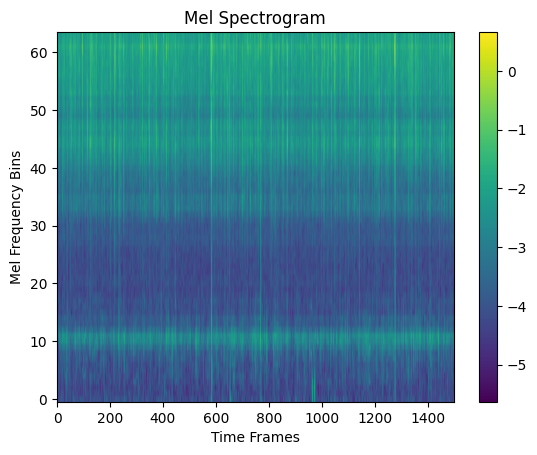

In [39]:
import matplotlib.pyplot as plt

# Access the spectrogram batch correctly from the dictionary
spectrograms_batch = samples['spectrogram']

# Plot the first spectrogram in the batch
plt.imshow(spectrograms_batch[0][:, :, 0].T, aspect='auto', origin='lower')
plt.colorbar()
plt.title("Mel Spectrogram")
plt.xlabel("Time Frames")
plt.ylabel("Mel Frequency Bins")
plt.show()


# 1st Model

In [40]:
import keras_tuner as kt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, 
    Dropout, GlobalAveragePooling2D, Dense, concatenate
)
import tensorflow as tf
from keras_tuner import Hyperband

def build_model(hp):
    # Spectrogram input
    spect_input = Input(shape=(1499, 64, 1), name='spectrogram')

    # Block 1
    x = Conv2D(
        filters=hp.Int('conv1_filters', 16, 64, 16),
        kernel_size=(7, 7), padding='same'
    )(spect_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(hp.Float('dropout1', 0.0, 0.4, 0.1))(x)

    # Block 2
    x = Conv2D(
        filters=hp.Int('conv2_filters', 32, 128, 32),
        kernel_size=(3, 3), padding='same'
    )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(hp.Float('dropout2', 0.1, 0.5, 0.1))(x)

    # Block 3
    x = Conv2D(
        filters=hp.Int('conv3_filters', 32, 128, 32),
        kernel_size=(3, 3), padding='same'
    )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(hp.Float('dropout3', 0.3, 0.6, 0.1))(x)

    x = GlobalAveragePooling2D()(x)

    # Extra feature branch
    extra_input = Input(shape=(2,), name='extra_features')
    y = Dense(
        units=hp.Int('dense_extra', 8, 32, step=8),
        activation='relu'
    )(extra_input)

    # Combine
    combined = concatenate([x, y])
    combined = Dense(
        units=hp.Int('dense_combined', 32, 128, 32),
        activation='relu'
    )(combined)
    combined = Dropout(hp.Float('dropout_combined', 0.3, 0.6, 0.1))(combined)

    # Output
    output = Dense(
        1,
        activation='sigmoid'
    )(combined)

    # Optimizer: plain Adam
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7])
    )

    model = Model(
        inputs={'spectrogram': spect_input, 'extra_features': extra_input},
        outputs=output
    )
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', 'Precision', 'Recall']
    )

    return model


In [41]:
train_batch = int(((samples_per_class*8)/batch_size)*0.8)
val_batch = int(((samples_per_class*8)/batch_size)*0.2)
print("Batches:", batch_size)
print("Batches for training", train_batch)
print("Batches for testing", val_batch)

Batches: 16
Batches for training 3200
Batches for testing 800


In [42]:
from keras_tuner import RandomSearch

tuner = RandomSearch(
    build_model,                # your model-building function
    objective="val_loss",       # optimize for validation loss
    max_trials=15,              # number of hyperparameter combinations to try
    executions_per_trial=1,     # average over multiple runs if desired
    directory="tuner_dir",
    project_name="reef_multiinput_audio",
    overwrite=True
)

In [44]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True,
    verbose=1
)


In [ ]:
tuner.search(
    train,
    validation_data=val,
    epochs=15,
    steps_per_epoch=train_batch,
    validation_steps=val_batch,
    callbacks=[early_stop]
)

Trial 15 Complete [00h 07m 27s]
val_loss: 0.6404588222503662

Best val_loss So Far: 0.3439282178878784
Total elapsed time: 01h 44m 35s

Search: Running Trial #16

Value             |Best Value So Far |Hyperparameter
64                |48                |conv1_filters
0.1               |0.2               |dropout1
32                |32                |conv2_filters
0.2               |0.1               |dropout2
32                |96                |conv3_filters
0.3               |0.3               |dropout3
32                |32                |dense_extra
64                |96                |dense_combined
0.4               |0.5               |dropout_combined
0.001             |0.0001            |learning_rate

Epoch 1/30
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 52s 15ms/step - Precision: 0.9048 - Recall: 0.8406 - accuracy: 0.9555 - loss: 0.1343 - val_Precision: 0.5221 - val_Recall: 0.0349 - val_accuracy: 0.5243 - val_loss: 1.8582
Epoch 2/30
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 47s 15ms/step - Prec

In [ ]:
tuner.results_summary()

Results summary
Results in tuner_dir/reef_multiinput_audio
Showing 10 best trials
Objective(name="val_loss", direction="min")


In [69]:
from keras_tuner import HyperParameters

best_hps = HyperParameters()
best_hps.values = {
    'conv1_filters': 48,
    'dropout1': 0.2,
    'conv2_filters': 32,
    'dropout2': 0.1,
    'conv3_filters': 96,
    'dropout3': 0.3,
    'dense_extra': 32,
    'dense_combined': 96,
    'dropout_combined': 0.5,
    'learning_rate': 0.0001
}


In [94]:
# ---------------------------------------------------------
# 11. Train the model
# ---------------------------------------------------------

# 1. Retrieve the best hyperparameters
#best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# (Optional) print them out to inspect
print("Best hyperparameters found:")
for hp_name in best_hps.values:
    print(f"  {hp_name}: {best_hps.get(hp_name)}")

# 2. Build a brand‑new model with those hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# 3. (Re‑)compile is already done inside build_model, but if you need to change:
# best_model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=best_hps.get('learning_rate')),
#     loss='binary_crossentropy',
#     metrics=['accuracy','Precision','Recall']
# )
final_early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True,
    verbose=1
)


# 4. Fit on the full training set, validating on your val split
history = best_model.fit(
    train, 
    validation_data=val,
    epochs=50,               # you can raise this now that you know good hp
    steps_per_epoch=train_batch,
    validation_steps=val_batch,
    callbacks=[final_early_stop]   # reuse your EarlyStopping if you like
)


Best hyperparameters found:
  conv1_filters: 48
  dropout1: 0.2
  conv2_filters: 32
  dropout2: 0.1
  conv3_filters: 96
  dropout3: 0.3
  dense_extra: 32
  dense_combined: 96
  dropout_combined: 0.5
  learning_rate: 0.0001
Epoch 1/50


I0000 00:00:1744979107.417371   46781 service.cc:148] XLA service 0x7f50a8006bc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744979107.417448   46781 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-04-18 13:25:07.461281: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744979107.669789   46781 cuda_dnn.cc:529] Loaded cuDNN version 90501


   7/3200 ━━━━━━━━━━━━━━━━━━━━ 1:17 24ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.9371 - loss: 0.2548 

I0000 00:00:1744979110.411063   46781 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3200/3200 ━━━━━━━━━━━━━━━━━━━━ 718s 221ms/step - Precision: 0.8549 - Recall: 0.8069 - accuracy: 0.9203 - loss: 0.2338 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5256 - val_loss: 3.1236
Epoch 2/50
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 102s 32ms/step - Precision: 0.9528 - Recall: 0.9621 - accuracy: 0.9546 - loss: 0.1420 - val_Precision: 1.0000 - val_Recall: 3.2000e-04 - val_accuracy: 0.5119 - val_loss: 2.2963
Epoch 3/50
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - Precision: 0.9688 - Recall: 0.9632 - accuracy: 0.9693 - loss: 0.0961 - val_Precision: 1.0000 - val_Recall: 1.4539e-04 - val_accuracy: 0.4627 - val_loss: 4.2248
Epoch 4/50
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - Precision: 0.9740 - Recall: 0.9763 - accuracy: 0.9752 - loss: 0.0792 - val_Precision: 0.9459 - val_Recall: 0.8928 - val_accuracy: 0.9249 - val_loss: 0.2101
Epoch 5/50
3200/3200 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - Precision: 0.9748 - Recall: 0.9721 - accuracy: 0.9731 - loss: 0.0787 - val_Pre

# Validation

In [95]:
val_subset = val.take(val_batch)

eval_results = best_model.evaluate(
    val_subset,
    steps=val_batch,
    return_dict=True,
    verbose=1
)

print("\nBest Model Evaluation on validation data:")
for metric_name, metric_value in eval_results.items():
    print(f"{metric_name}: {metric_value:.4f}")

800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - Precision: 0.8188 - Recall: 0.9197 - accuracy: 0.9242 - loss: 0.1807

Best Model Evaluation on validation data:
Precision: 0.9459
Recall: 0.8928
accuracy: 0.9249
loss: 0.2101


In [96]:
from sklearn.metrics import f1_score, roc_auc_score
import numpy as np

# Get predictions
y_probs = best_model.predict(val.take(val_batch), verbose=0)
y_pred = (y_probs > 0.5).astype("int32")

# Get true labels
y_true = np.concatenate([y.numpy() for _, y in val.take(val_batch)])

# Compute metrics
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_probs)

print("\nAdditional Metrics:")
print(f"F1 Score : {f1:.4f}")
print(f"ROC AUC  : {roc_auc:.4f}")


Additional Metrics:
F1 Score : 0.9186
ROC AUC  : 0.9748


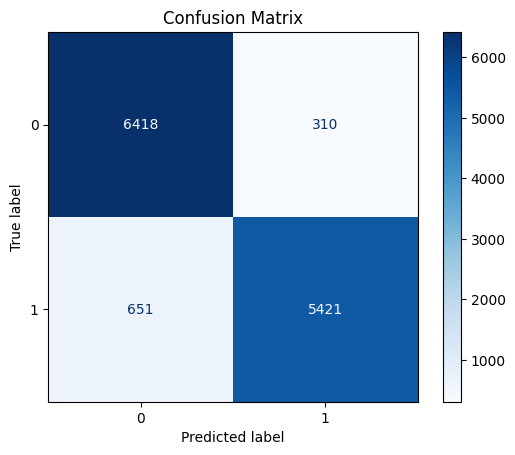

In [97]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


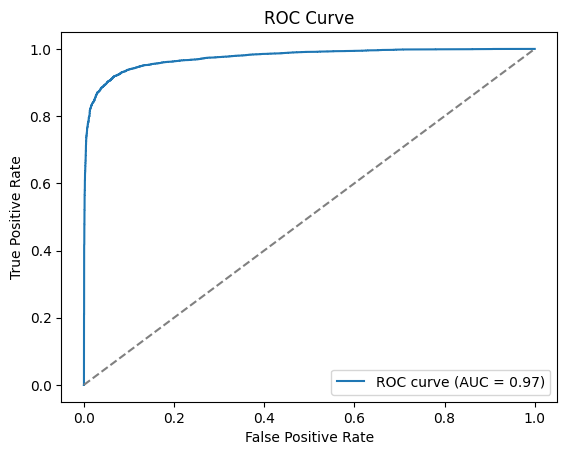

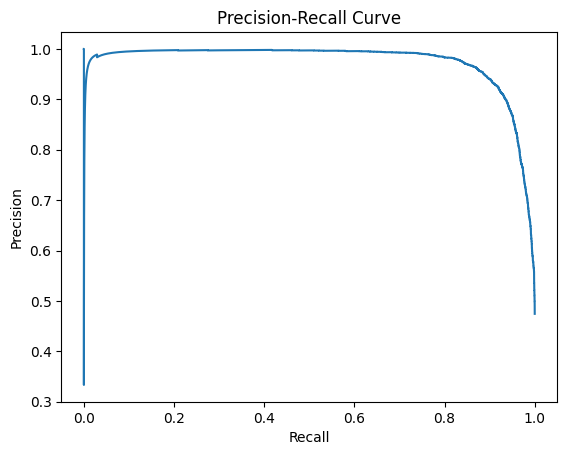

In [98]:
from sklearn.metrics import roc_curve, precision_recall_curve

fpr, tpr, _ = roc_curve(y_true, y_probs)
precision, recall, _ = precision_recall_curve(y_true, y_probs)

# ROC Curve
plt.figure()
plt.plot(fpr, tpr, label="ROC curve (AUC = %.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# PR Curve
plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()


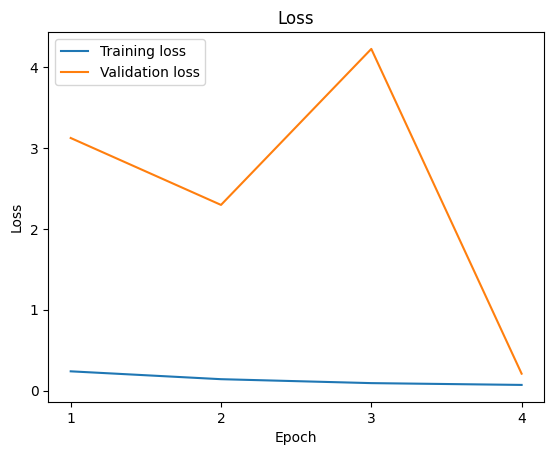

In [110]:
import matplotlib.pyplot as plt

# Find the epoch with the best (lowest) validation loss
best_epoch = history.history['val_loss'].index(min(history.history['val_loss'])) + 1  # +1 to shift from 0-indexed

# Slice data up to the best epoch
epochs = list(range(1, best_epoch + 1))
train_loss = history.history['loss'][:best_epoch]
val_loss = history.history['val_loss'][:best_epoch]

plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)
plt.title(f"Loss")
plt.show()


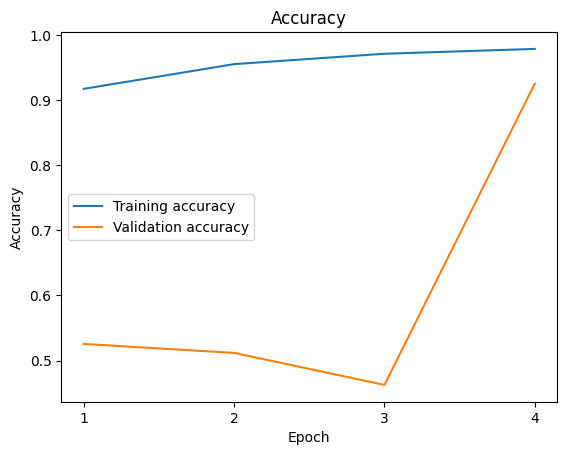

In [112]:
plt.plot(epochs, history.history['accuracy'][:best_epoch], label='Training accuracy')
plt.plot(epochs, history.history['val_accuracy'][:best_epoch], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(epochs)
plt.title('Accuracy')
plt.show()


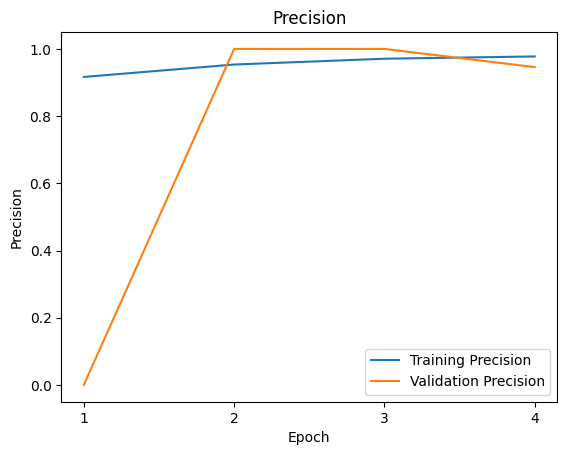

In [114]:
plt.plot(epochs, history.history['Precision'][:best_epoch], label='Training Precision')
plt.plot(epochs, history.history['val_Precision'][:best_epoch], label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.xticks(epochs)
plt.title('Precision')
plt.show()

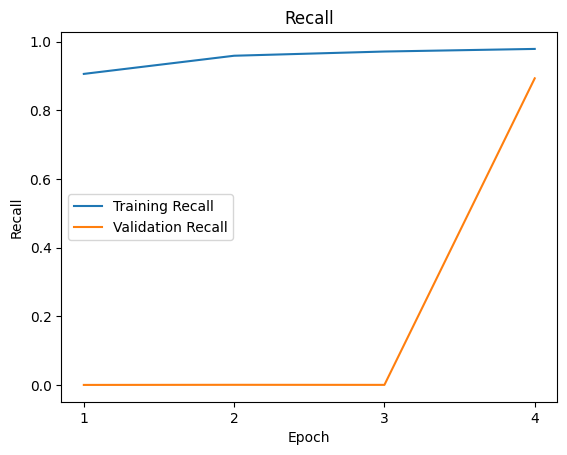

In [116]:
plt.plot(epochs, history.history['Recall'][:best_epoch], label='Training Recall')
plt.plot(epochs, history.history['val_Recall'][:best_epoch], label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.xticks(epochs)
plt.title('Recall')
plt.show()

In [ ]:
#best_model.save_weights('my_trained_model.weights.h5')

# 2nd Model

In [45]:
samples_per_class = 1440  

In [46]:
#kenya_dir    = '/mnt/f/mars_global_acoustic_study/kenya_acoustics_vids/Audio/'
#files_kenya = get_files_for_dataset(kenya_dir, ds_id=5, samples_per_class=samples_per_class)

In [47]:
#with open("files_kenya.txt", "w") as f:
#    for entry in files_kenya[:30000]:  # Limit if needed
#        f.write(str(entry) + "\n")

In [46]:
files_kenya = []
with open("files_kenya.txt", "r") as f:
    for line in f:
        files_kenya.append(ast.literal_eval(line.strip()))

print(f"Loaded {len(files_kenya)} files.")

Loaded 26000 files.


In [47]:
# Split files into positive and negative
positive_files = [f for f in files_kenya if f[1] == 1]
negative_files = [f for f in files_kenya if f[1] == 0]

In [48]:
len(positive_files)

13000

In [49]:
len(negative_files)

13000

In [50]:
import random

random.shuffle(positive_files)
random.shuffle(negative_files)

train_pos = positive_files[:samples_per_class]
train_neg = negative_files[:samples_per_class]
train_files = train_pos + train_neg
random.shuffle(train_files)

In [51]:
remaining_pos = positive_files[samples_per_class:]
remaining_neg = negative_files[samples_per_class:]
remaining = remaining_pos + remaining_neg

In [52]:
from sklearn.model_selection import train_test_split
import random

# Ensure it's shuffled before the split
remaining_pos = positive_files[samples_per_class:]
remaining_neg = negative_files[samples_per_class:]
remaining = remaining_pos + remaining_neg
random.shuffle(remaining)

# 50/50 split of remaining data into val and test
val_files, test_files = train_test_split(
    remaining,
    test_size=0.5,
    stratify=[f[1] for f in remaining]  # Use label for stratification
)

In [53]:
print(len(train_files))
print(len(val_files))
print(len(test_files))

2880
11560
11560


In [54]:
# Train
file_paths   = [f[0] for f in train_files]
dataset_ids  = [f[2] for f in train_files]
labels       = [f[1] for f in train_files]
train_ds = tf.data.Dataset.from_tensor_slices(((file_paths, dataset_ids), labels))
train_ds = train_ds.shuffle(2048).map(preprocess_mel, num_parallel_calls=tf.data.AUTOTUNE).batch(8).prefetch(tf.data.AUTOTUNE)
train_ds = train_ds.cache()

# Validation
file_paths   = [f[0] for f in val_files]
dataset_ids  = [f[2] for f in val_files]
labels       = [f[1] for f in val_files]
val_ds = tf.data.Dataset.from_tensor_slices(((file_paths, dataset_ids), labels))
val_ds = val_ds.map(preprocess_mel, num_parallel_calls=tf.data.AUTOTUNE).batch(8).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache()

# Test
file_paths   = [f[0] for f in test_files]
dataset_ids  = [f[2] for f in test_files]
labels       = [f[1] for f in test_files]
test_ds = tf.data.Dataset.from_tensor_slices(((file_paths, dataset_ids), labels))
test_ds = test_ds.map(preprocess_mel, num_parallel_calls=tf.data.AUTOTUNE).batch(8).prefetch(tf.data.AUTOTUNE)


In [55]:
from keras_tuner import HyperParameters

best_hps = HyperParameters()
best_hps.values = {
    'conv1_filters': 48,
    'dropout1': 0.2,
    'conv2_filters': 32,
    'dropout2': 0.1,
    'conv3_filters': 96,
    'dropout3': 0.3,
    'dense_extra': 32,
    'dense_combined': 96,
    'dropout_combined': 0.5,
    'learning_rate': 0.0001
}


In [57]:
def build_lightweight_tuned_model(hp):
    # Build lightweight model
    spect_input = tf.keras.Input(shape=(1499, 64, 1), name='spectrogram')
    conv1_filters = hp.Int('conv1_filters', min_value=8, max_value=64, step=8)
    x = tf.keras.layers.Conv2D(conv1_filters, (3, 3), activation='relu', padding='same', name="conv1")(spect_input)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    conv2_filters = hp.Int('conv2_filters', min_value=16, max_value=64, step=8)
    x = tf.keras.layers.Conv2D(conv2_filters, (3, 3), activation='relu', padding='same', name="conv2")(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    extra_input = tf.keras.Input(shape=(2,), name='extra_features')
    combined = tf.keras.layers.concatenate([x, extra_input])

    dense_units = hp.Int('dense_units', 32, 128, step=32)
    dropout_rate = hp.Float('dropout_rate', 0.1, 0.5, step=0.1)
    x = tf.keras.layers.Dense(dense_units, activation='relu', name='fc')(combined)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    output = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(x)

    model = tf.keras.Model(inputs={'spectrogram': spect_input, 'extra_features': extra_input}, outputs=output)

    # ✅ Load weights from pretrained model and transfer
    try:
        pretrained = build_model(best_hps)
        pretrained.load_weights("my_trained_model.weights.h5")

        # Transfer matching layers
        for lw in model.layers:
            for pw in pretrained.layers:
                if lw.name == pw.name and lw.get_weights():
                    lw.set_weights(pw.get_weights())
                    lw.trainable = False  # optional: freeze layer
                    print(f"✅ Transferred weights to: {lw.name}")
    except Exception as e:
        print("Could not load weights:", e)

    # Optimizer
    learning_rate = hp.Float('learning_rate', 1e-5, 1e-2, sampling='log')
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    return model


In [58]:
from keras_tuner import RandomSearch
import shutil, os

# Clean previous tuner run
tuner_dir = "tuner_transfer_light"
project_name = "kenya_light_cnn"
tuner_path = os.path.join(tuner_dir, project_name)

if os.path.exists(tuner_path):
    shutil.rmtree(tuner_path)
    print("🧹 Cleared previous tuner results.")

tuner = RandomSearch(
    build_lightweight_tuned_model,
    objective="val_loss",
    max_trials=20,
    executions_per_trial=1,
    directory=tuner_dir,
    project_name=project_name,
    overwrite=True
)


🧹 Cleared previous tuner results.


/home/os/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [61]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True,
    verbose=1
)

tuner.search(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop]
)


Trial 20 Complete [00h 01m 54s]
val_loss: 0.20171916484832764

Best val_loss So Far: 0.04184052720665932
Total elapsed time: 00h 28m 53s


In [62]:
best_model = tuner.get_best_models(1)[0]
new_best_hps = tuner.get_best_hyperparameters(1)[0]

print("Best hyperparameters found:")
for hp in new_best_hps.values:
    print(f"{hp}: {new_best_hps.get(hp)}")

# Optional: train best model again
history = best_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop]
)

Best hyperparameters found:
conv1_filters: 24
conv2_filters: 16
dense_units: 128
dropout_rate: 0.2
learning_rate: 0.0026664989979791314
Epoch 1/30


/home/os/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


360/360 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9697 - loss: 0.0669 - precision: 0.9715 - recall: 0.9696 - val_accuracy: 0.9792 - val_loss: 0.0573 - val_precision: 0.9889 - val_recall: 0.9692
Epoch 2/30
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9726 - loss: 0.0620 - precision: 0.9777 - recall: 0.9689 - val_accuracy: 0.9774 - val_loss: 0.0544 - val_precision: 0.9925 - val_recall: 0.9621
Epoch 3/30
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9704 - loss: 0.0707 - precision: 0.9745 - recall: 0.9678 - val_accuracy: 0.9817 - val_loss: 0.0473 - val_precision: 0.9919 - val_recall: 0.9713
Epoch 4/30
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9766 - loss: 0.0582 - precision: 0.9814 - recall: 0.9730 - val_accuracy: 0.9784 - val_loss: 0.0568 - val_precision: 0.9915 - val_recall: 0.9651
Epoch 5/30
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9736 - loss: 0.0590 - precision: 0.9751 - recall: 0.9737 - val_accuracy: 0.9721 - val_loss: 0.0660 - val

# Validation

In [65]:
val_subset = val_ds

eval_results = best_model.evaluate(
    val_subset,
    steps=val_batch,
    return_dict=True,
    verbose=1
)

print("\nBest Model Evaluation on validation data:")
for metric_name, metric_value in eval_results.items():
    print(f"{metric_name}: {metric_value:.4f}")

  4/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 0.0149 - precision: 1.0000 - recall: 1.0000    

800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9877 - loss: 0.0388 - precision: 0.9905 - recall: 0.9851

Best Model Evaluation on validation data:
accuracy: 0.9877
loss: 0.0369
precision: 0.9900
recall: 0.9853


In [66]:
from sklearn.metrics import f1_score, roc_auc_score
import numpy as np

# Get predictions
y_probs = best_model.predict(val_subset, verbose=0)
y_pred = (y_probs > 0.5).astype("int32")

# Get true labels
y_true = np.concatenate([y.numpy() for _, y in val_subset])

# Compute metrics
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_probs)

print("\nAdditional Metrics:")
print(f"F1 Score : {f1:.4f}")
print(f"ROC AUC  : {roc_auc:.4f}")


Additional Metrics:
F1 Score : 0.9872
ROC AUC  : 0.9992


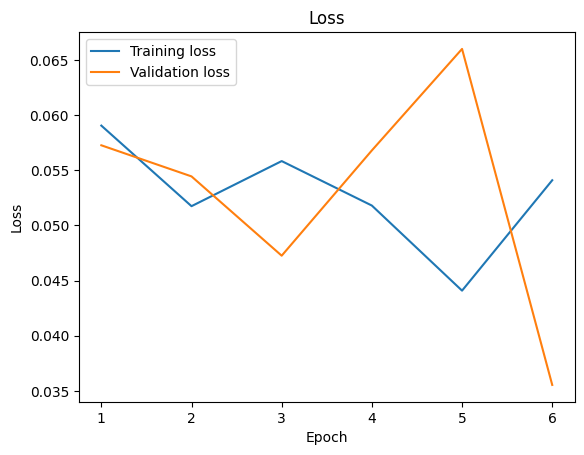

In [69]:
import matplotlib.pyplot as plt

# Find the epoch with the best (lowest) validation loss
best_epoch = history.history['val_loss'].index(min(history.history['val_loss'])) + 1  # +1 to shift from 0-indexed

# Slice data up to the best epoch
epochs = list(range(1, best_epoch + 1))
train_loss = history.history['loss'][:best_epoch]
val_loss = history.history['val_loss'][:best_epoch]

plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)
plt.title(f"Loss")
plt.show()


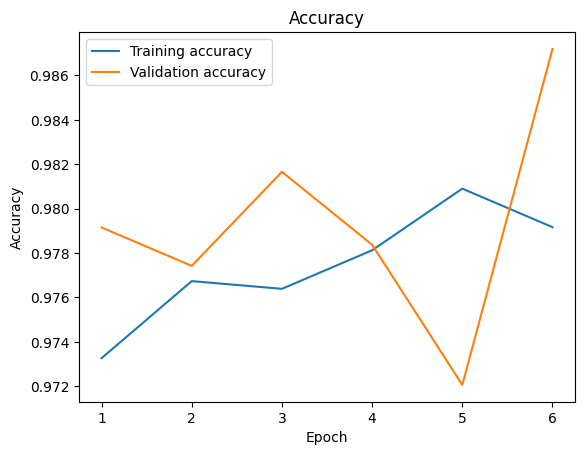

In [70]:
plt.plot(epochs, history.history['accuracy'][:best_epoch], label='Training accuracy')
plt.plot(epochs, history.history['val_accuracy'][:best_epoch], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(epochs)
plt.title('Accuracy')
plt.show()

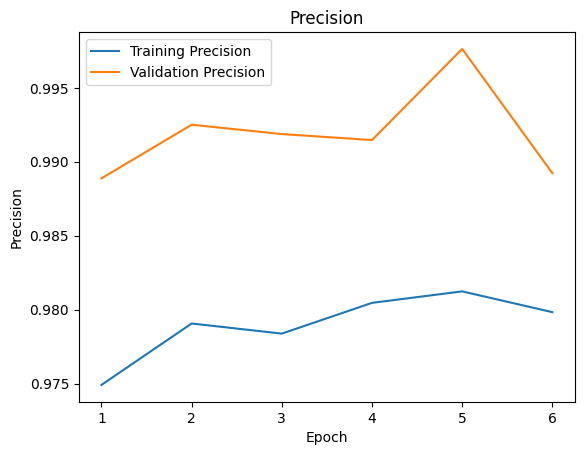

In [71]:
plt.plot(epochs, history.history['precision'][:best_epoch], label='Training Precision')
plt.plot(epochs, history.history['val_precision'][:best_epoch], label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.xticks(epochs)
plt.title('Precision')
plt.show()

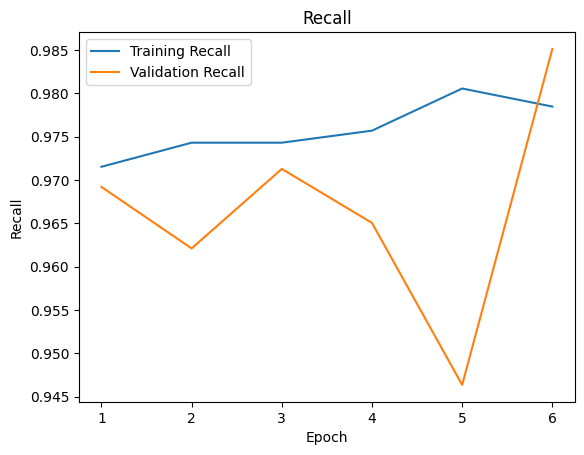

In [72]:
plt.plot(epochs, history.history['recall'][:best_epoch], label='Training Recall')
plt.plot(epochs, history.history['val_recall'][:best_epoch], label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.xticks(epochs)
plt.title('Recall')
plt.show()

# Test

In [73]:
eval_results = best_model.evaluate(
    test_ds,
    steps=val_batch,
    return_dict=True,
    verbose=1
)

print("\nBest Model Evaluation on test data:")
for metric_name, metric_value in eval_results.items():
    print(f"{metric_name}: {metric_value:.4f}")

800/800 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - accuracy: 0.9872 - loss: 0.0371 - precision: 0.9893 - recall: 0.9843

Best Model Evaluation on test data:
accuracy: 0.9889
loss: 0.0324
precision: 0.9905
recall: 0.9871


In [74]:
from sklearn.metrics import f1_score, roc_auc_score
import numpy as np

# Get predictions
y_probs = best_model.predict(test_ds, verbose=0)
y_pred = (y_probs > 0.5).astype("int32")

# Get true labels
y_true = np.concatenate([y.numpy() for _, y in test_ds])

# Compute metrics
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_probs)

print("\nAdditional Metrics:")
print(f"F1 Score : {f1:.4f}")
print(f"ROC AUC  : {roc_auc:.4f}")


Additional Metrics:
F1 Score : 0.9883
ROC AUC  : 0.9992


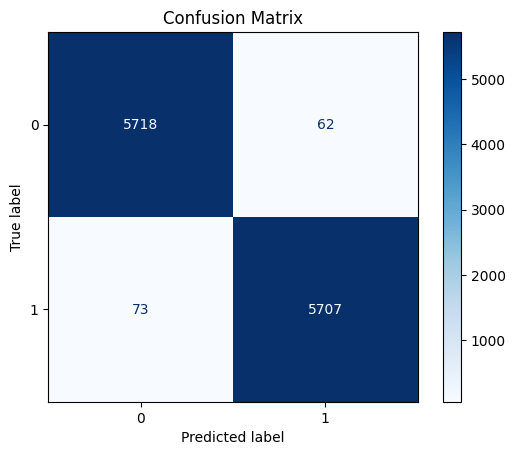

In [75]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


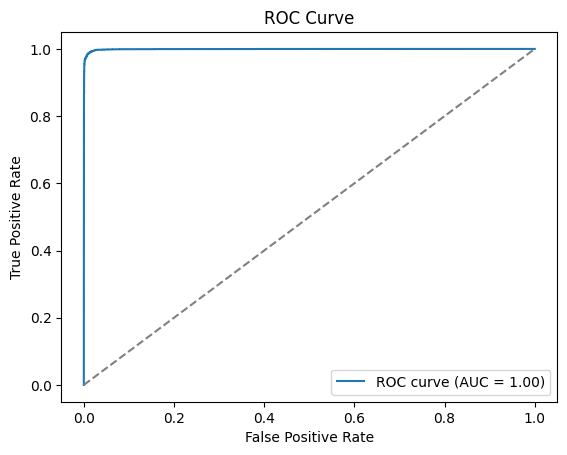

In [76]:
from sklearn.metrics import roc_curve, precision_recall_curve

fpr, tpr, _ = roc_curve(y_true, y_probs)
precision, recall, _ = precision_recall_curve(y_true, y_probs)

# ROC Curve
plt.figure()
plt.plot(fpr, tpr, label="ROC curve (AUC = %.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Edge Testing

In [91]:
import time

# Time the evaluation
start_time = time.time()
eval_results = best_model.evaluate(
    test_ds,
    steps=val_batch,  # Make sure this is set correctly or just remove it
    return_dict=True,
    verbose=1
)
end_time = time.time()

# Calculate elapsed time and average inference time per sample
total_time = end_time - start_time
num_samples = test_ds.cardinality().numpy() * 8  # 8 is your batch size

avg_inference_time = total_time / num_samples
throughput_s = num_samples / total_time

# Print everything
print(f"\nTotal evaluation time: {total_time:.2f} seconds")
print(f"Number of samples: {num_samples}")
print(f"Average inference time per sample: {avg_inference_time * 1000:.2f} ms")
print(f"Throughput: {throughput_s:.2f} samples/sec\n")

800/800 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.9872 - loss: 0.0371 - precision: 0.9893 - recall: 0.9843

Total evaluation time: 19.97 seconds
Number of samples: 11560
Average inference time per sample: 1.73 ms
Throughput: 578.90 samples/sec



In [84]:
import tracemalloc

# Start memory tracking
tracemalloc.start()

# Run evaluation
_ = best_model.evaluate(test_ds, verbose=0)

# Get memory usage in MB
current, peak = tracemalloc.get_traced_memory()
print(f"\nMemory used during inference: {current / 10**6:.2f} MB")
print(f"Peak memory during inference: {peak / 10**6:.2f} MB")

# Stop memory tracking
tracemalloc.stop()


Memory used during inference: 0.03 MB
Peak memory during inference: 0.05 MB


In [ ]:
# Save weights 
weights_path = "final.weights.h5"
#best_model.save_weights(weights_path)

In [87]:
import os

size_bytes = os.path.getsize(weights_path)
size_mb = size_bytes / (1024 * 1024)

print(f"Saved model weights size: {size_mb:.2f} MB")

Saved model weights size: 0.11 MB
